In [1]:
import os
from numpy.lib.format import open_memmap
import numpy as np
import matplotlib.pyplot as plt
from radioNN.data.loader import AntennaDataset
import warnings

warnings.simplefilter("ignore", np.RankWarning)
def split_sim_number(nn):
    """Split the number to two parts."""
    a = nn // 100
    b = nn % 100
    return a, b

def sim_to_id(nn):
    sim_1, sim_2 = split_sim_number(nn)
    return (sim_1 - 1) * 27 + (sim_2 - 1)

def id_to_sim(idx):
    return (idx//27 + 1)*100 + (idx%27 + 1)

#RADIO_DATA_PATH = "/Volumes/DenisDRIVE/BACHELORTHESIS/memmap_files/memmap"
RADIO_DATA_PATH = "/Users/denis/Desktop/BachelorThesis/memmap/memmap"
if not os.path.exists(RADIO_DATA_PATH):
    RADIO_DATA_PATH = "/home/pranav/work-stuff-unsynced/radio_data"
assert os.path.exists(RADIO_DATA_PATH)
meta_data_file = os.path.join(RADIO_DATA_PATH, "meta_data.npy")
meta_data = open_memmap(meta_data_file, mode="r")
#output_gece_file = os.path.join(RADIO_DATA_PATH, "output_gece_data.npy")
#output_gece = open_memmap(output_gece_file, mode="r")
input_data_file = os.path.join(RADIO_DATA_PATH, "input_data.npy")
input_data = open_memmap(input_data_file, mode="r")
antenna_pos_data_file = os.path.join(RADIO_DATA_PATH, "antenna_pos_data.npy")
antenna_pos_data = open_memmap(antenna_pos_data_file, mode="r")
output_meta_file = os.path.join(RADIO_DATA_PATH, "output_meta_data.npy")
output_meta = open_memmap(output_meta_file, mode="r")
output_vBvvB_file = os.path.join(RADIO_DATA_PATH, "output_vBvvB_data.npy")
output_vBvvB = open_memmap(output_vBvvB_file, mode="r")
#fluence_vBvvB_file = os.path.join(RADIO_DATA_PATH, "fluence_vBvvB.npy")
#fluence_vBvvB = open_memmap(fluence_vBvvB_file, mode="r")
#fluence_gece_file = os.path.join(RADIO_DATA_PATH, "fluence_gece.npy")
#fluence_gece = open_memmap(fluence_gece_file, mode="r")



print(np.sum(meta_data[:,0] != 0)/len(meta_data[:,0])*100, "% done")
print((np.where(meta_data[:,0] == np.max(meta_data[:,0]))[0][0]+1)/len(meta_data[:,0])*100, "% done")

100.0 % done
100.0 % done


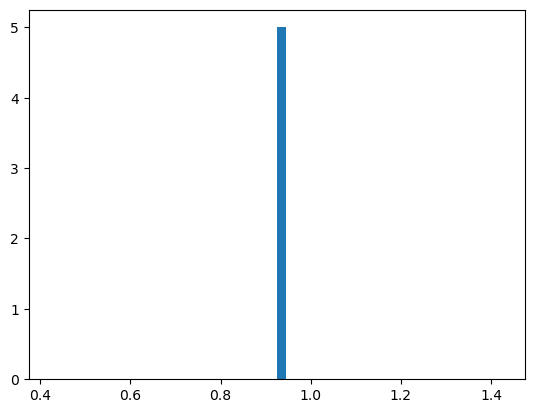

In [2]:
plt.hist((meta_data[:,1]), bins=50);

In [3]:
2158*27

58266

In [4]:
#np.sum(output_gece[0:27]**2, axis=2).shape

In [5]:
import tqdm

In [6]:
#fluence_vBvvB.shape

In [7]:
#np.sum(np.isinf(fluence_vBvvB))

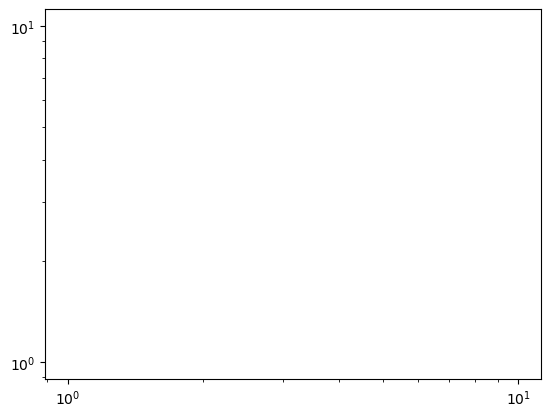

In [9]:
#plt.hist(fluence_vBvvB[np.isfinite(fluence_vBvvB)].flatten(), bins=1000);
plt.yscale('log')
plt.xscale('log')


In [10]:
from RadioPlotter.radio_plotter import plot_interpolated_footprint

In [11]:
np.where([True, False, True, False])

(array([0, 2]),)

In [12]:
assert False

AssertionError: 

In [ ]:
id_to_sim(33)

207

In [ ]:
print(np.where(meta_data[:,0] == np.max(meta_data[:,0]))[0][0],len(meta_data[:,0]))

11208 21524


In [ ]:
np.amax(np.where(input_data[200, :,0]!=0), axis=1)

array([1014])

In [13]:
np.where(meta_data[:,0] == 0)[0].shape[-1]/np.load("iterate_file.npy").shape[-1]*100

FileNotFoundError: [Errno 2] No such file or directory: 'iterate_file.npy'

In [14]:

indices = np.array([idd for idd in np.nditer(np.where(meta_data[:,0] != 0)) if np.all(np.isfinite(output_vBvvB[idd]))])


In [15]:
np.save('indices.npy', indices)

In [16]:
indices = np.load('indices.npy')

In [17]:
output_meta.shape

(5, 160, 2)

In [18]:
meta_data[-1,0]

46.0

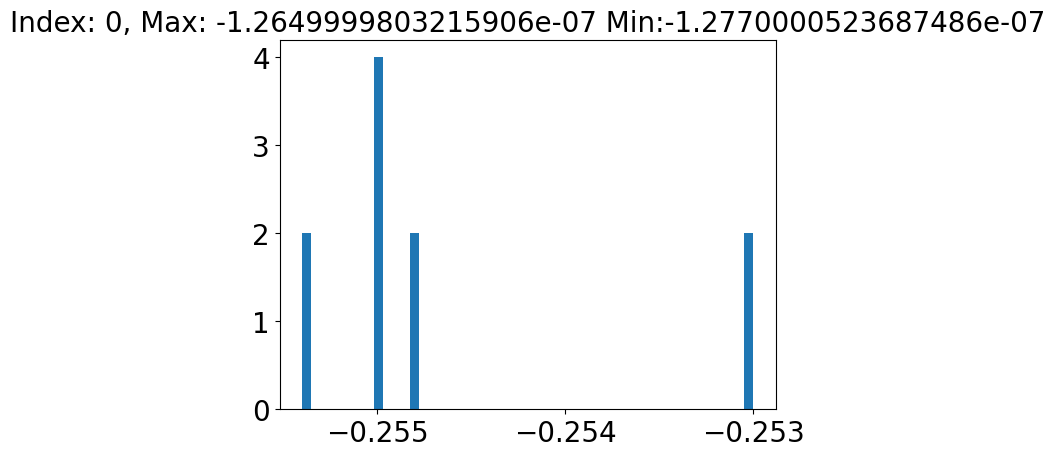

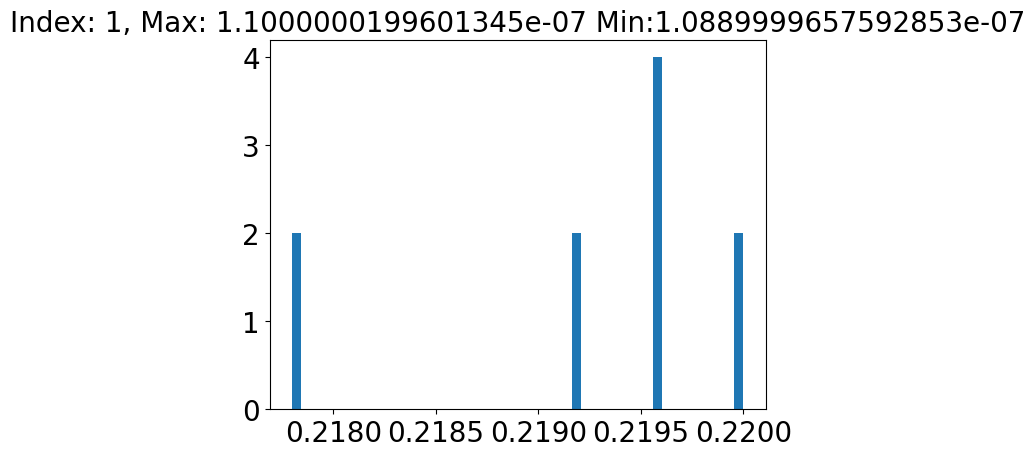

In [19]:
for i in range(2):
    plt.hist(output_meta[indices,i].flatten()/5e-7, bins=50)
    plt.title(f"Index: {i}, Max: {np.max(output_meta[indices,i])} Min:{np.min(output_meta[indices,i])}")
    #plt.xscale('log')
    plt.show()

In [20]:
def footprint(real, pos, meta, inp_meta, sc_fn=None, radius=np.inf):
    scalar = sc_fn(real, pos, meta)
    from scipy.interpolate import RBFInterpolator
    fig, ax = plt.subplot_mosaic("AB", figsize=(12, 10), gridspec_kw={"width_ratios": [90, 10]})
    x_pos = pos[:, 0]
    y_pos = pos[:, 1]
    xs = np.linspace(np.nanmin(x_pos), np.nanmax(x_pos), 100)
    ys = np.linspace(np.nanmin(y_pos), np.nanmax(y_pos), 100)
    xx, yy = np.meshgrid(xs, ys)
    # points within a circle
    in_star = np.array(xx**2 + yy**2 <= np.nanmax(x_pos**2 + y_pos**2))
    interp_func = RBFInterpolator(list(zip(x_pos, y_pos)), scalar, kernel="quintic")
    fp_interp = np.where(
        in_star.flatten(),
        interp_func(np.array([xx, yy]).reshape(2, -1).T),
        np.nan,
    ).reshape(100, 100)
    pcm = ax['A'].pcolormesh(
        xx,
        yy,
        fp_interp,
        vmin=np.percentile(scalar, 0),
        vmax=np.percentile(scalar, 100),
        cmap="inferno",
        shading="gouraud",
    )  # use shading="gouraud" to make it smoother
    _cbi = fig.colorbar(
        pcm, pad=0.5, cax=ax["B"], aspect=10, format=lambda x, _: f"{x:.1f}"
    )
    # _cbi.set_label(self._skey, fontsize=20)
    ax["A"].set_ylabel("vvB / m")
    ax["A"].set_xlabel("vB / m")
    ax["A"].set_facecolor("white")
    ax["A"].set_aspect(1)
    ax["A"].set_xlim(-radius, radius)
    ax["A"].set_ylim(-radius, radius)
    print("vmin = ", np.amin(scalar))
    print("vmax = ", np.amax(scalar))

    ax["A"].scatter(
        x_pos,
        y_pos,
        edgecolor="w",
        facecolor="none",
        s=5,
        lw=1.0,
    )

vmin =  2.089786805401835e-06
vmax =  0.3829964446254722


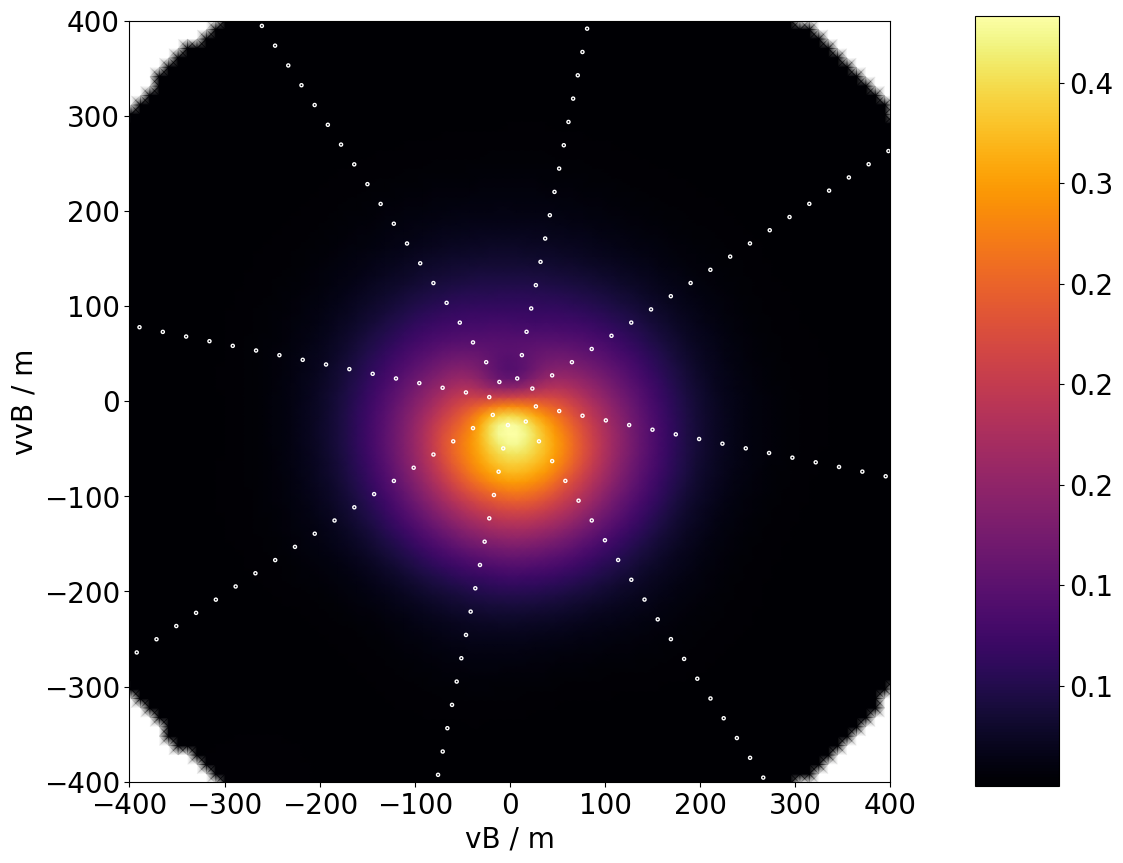

In [25]:
from view_scalars import get_fluences1 as sc_fn
index = 4
footprint(output_vBvvB[index], antenna_pos_data[index], output_meta[index]/5e-7, meta_data[index], sc_fn=sc_fn, radius=400)

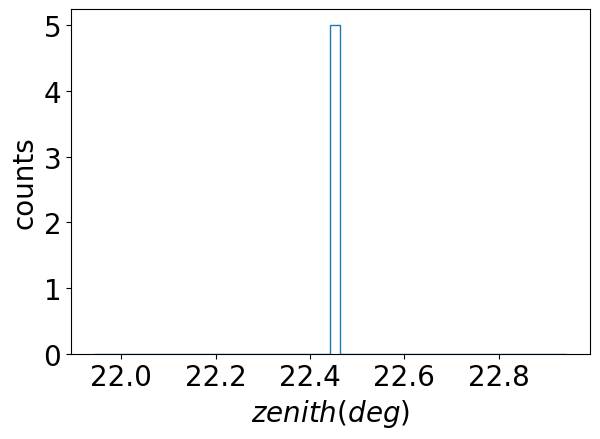

In [26]:
plt.hist(np.rad2deg(np.arccos(meta_data[indices,1])), bins=50, histtype='step')
#plt.title(f"Index: {i}, Max: {np.max(meta_data[indices,i])} Min:{np.min(meta_data[indices,i])}")
plt.xlabel(r'$zenith (deg)$')
plt.ylabel(r'counts')
#plt.yscale('')
#plt.xlim([0, 60])
plt.tight_layout()
plt.savefig('zenith.pdf')

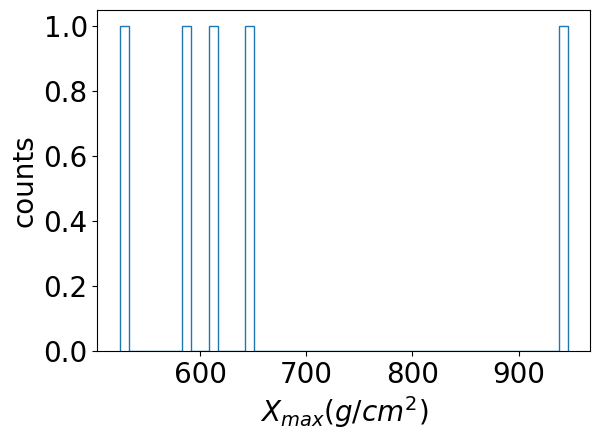

In [27]:
i = 2
plt.hist(meta_data[indices,i], bins=50, histtype='step')
#plt.title(f"Index: {i}, Max: {np.max(meta_data[indices,i])} Min:{np.min(meta_data[indices,i])}")
plt.xlabel(r'$X_{max} (g/cm^2)$')
plt.ylabel(r'counts')
#plt.xlim([500, 1400])
plt.tight_layout()
plt.savefig('xmax.pdf')

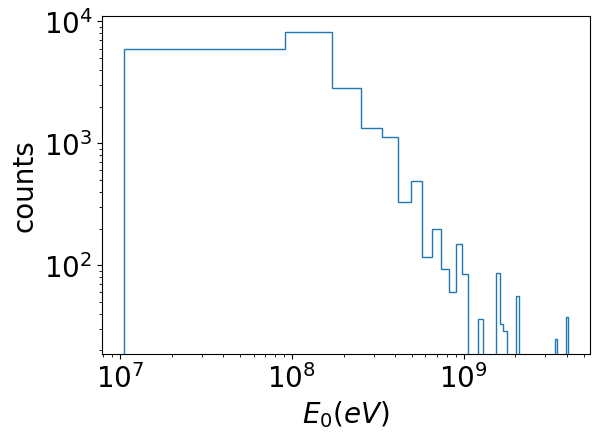

In [53]:
i = 11
plt.hist(meta_data[indices,i], bins=50, histtype='step')
#plt.title(f"Index: {i}, Max: {np.max(meta_data[indices,i])} Min:{np.min(meta_data[indices,i])}")
plt.xlabel(r'$E_0 (eV)$')
plt.ylabel(r'counts')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig('e0.pdf')

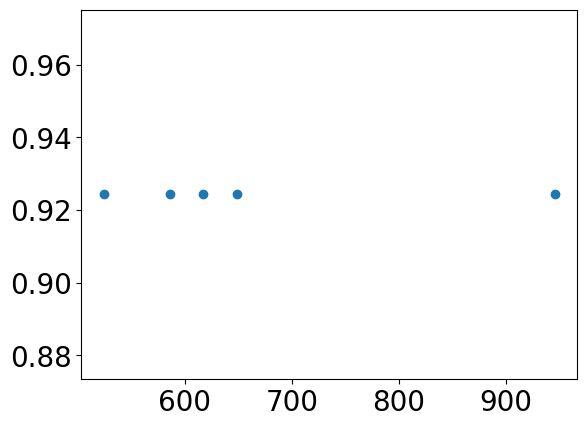

In [28]:
plt.scatter(meta_data[indices, 2], meta_data[indices,1])

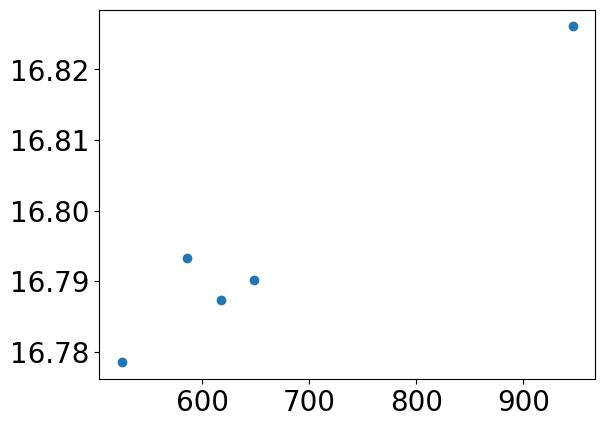

In [29]:
plt.scatter(meta_data[indices, 2], np.log10(meta_data[indices,5]))

/opt/anaconda3/envs/PuandaRadio/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


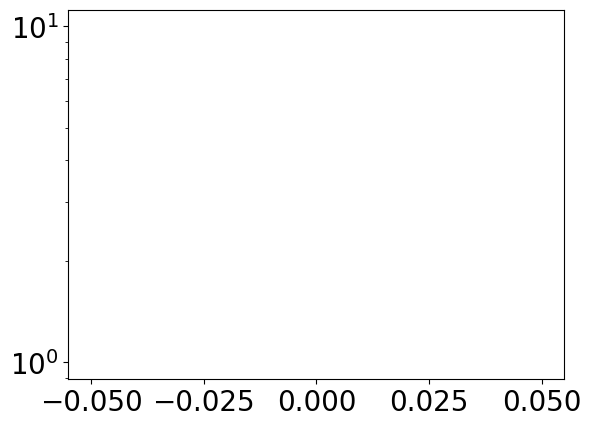

In [30]:
plt.hist(meta_data[indices, 2][np.abs(np.log10(meta_data[indices,5]) - 18) < 0.001], bins=50, density=True);
plt.yscale('log')

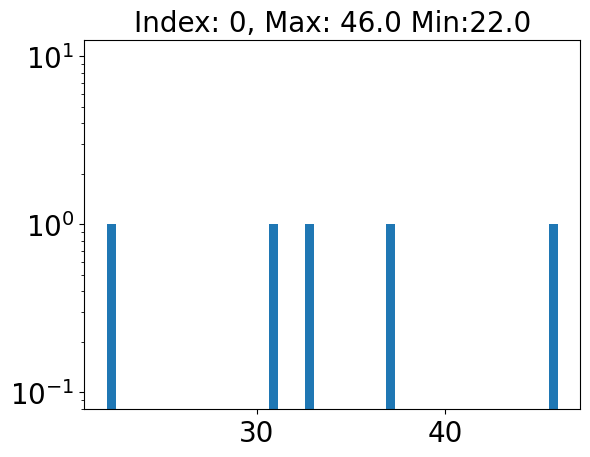

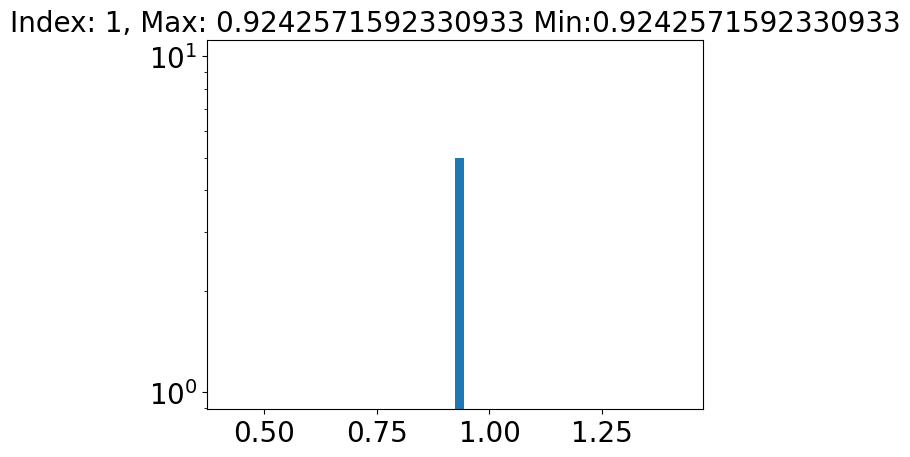

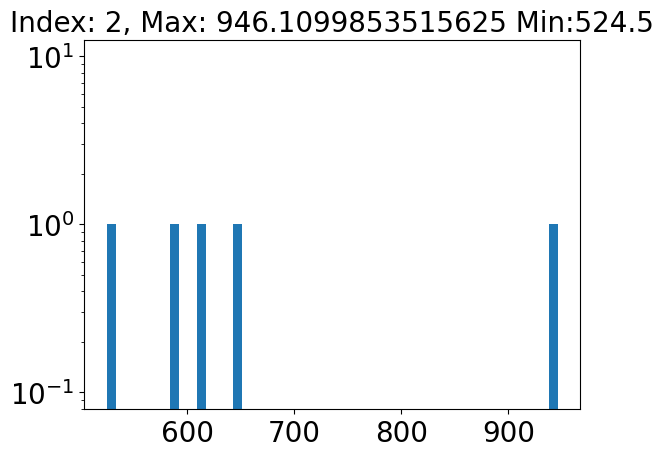

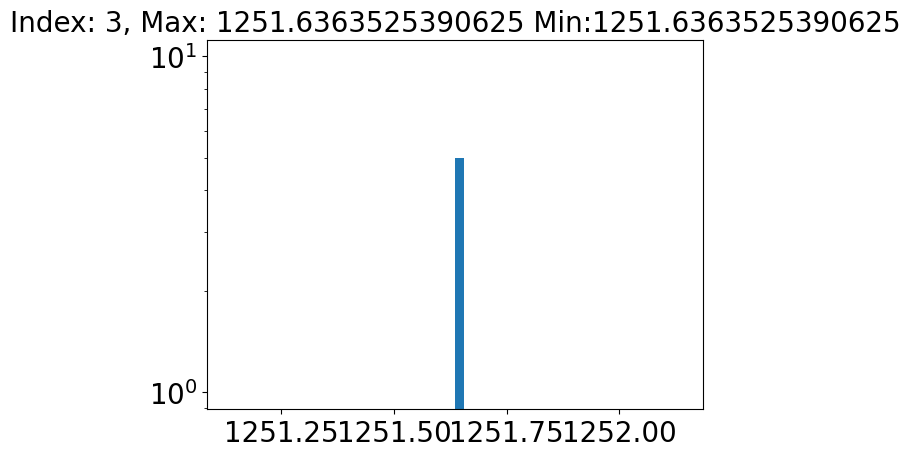

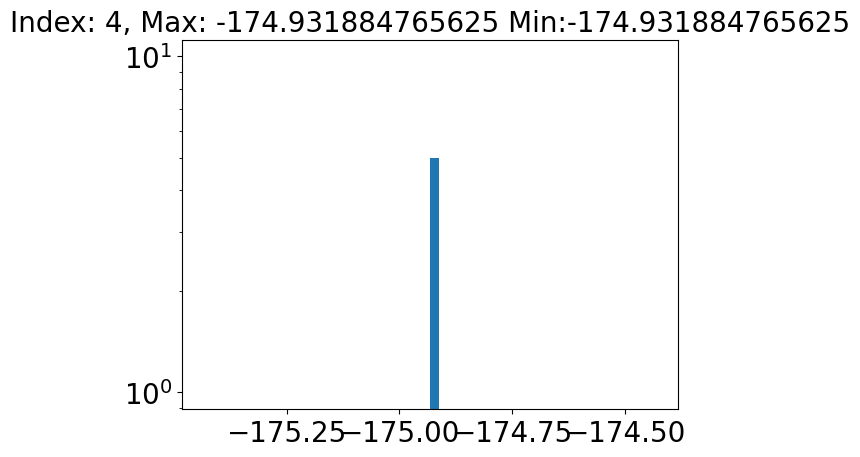

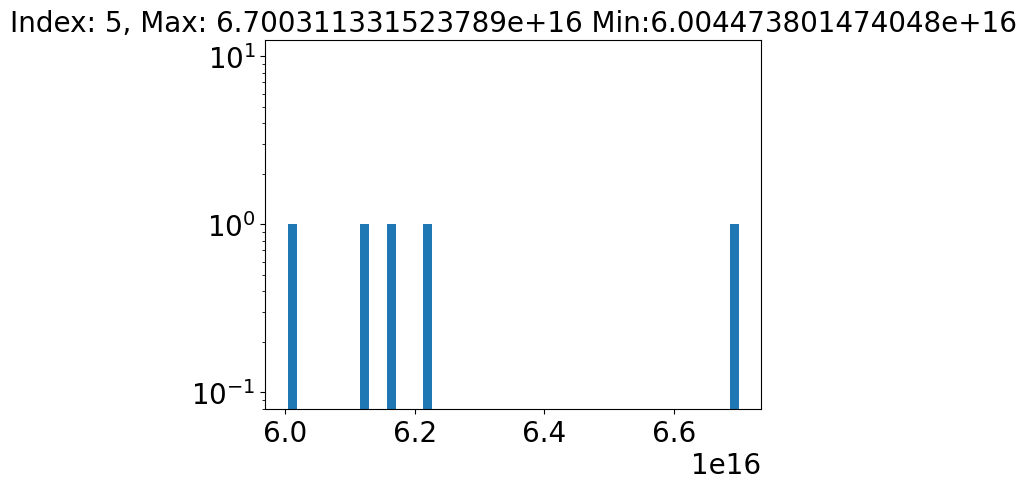

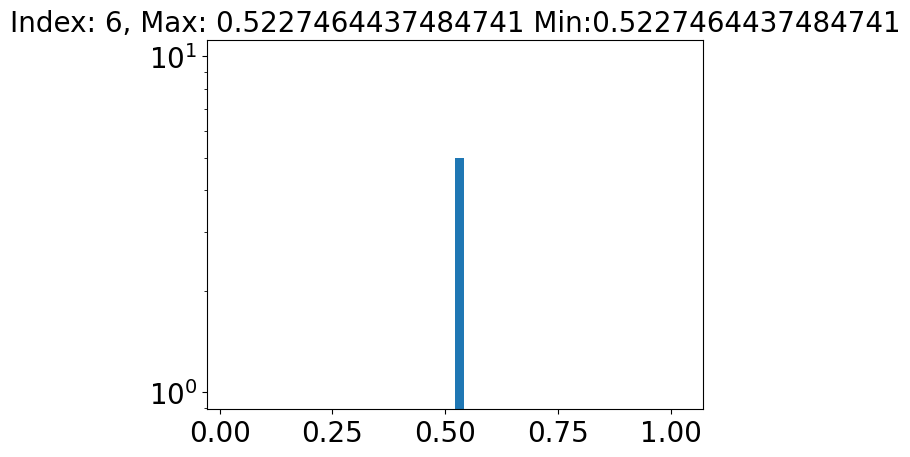

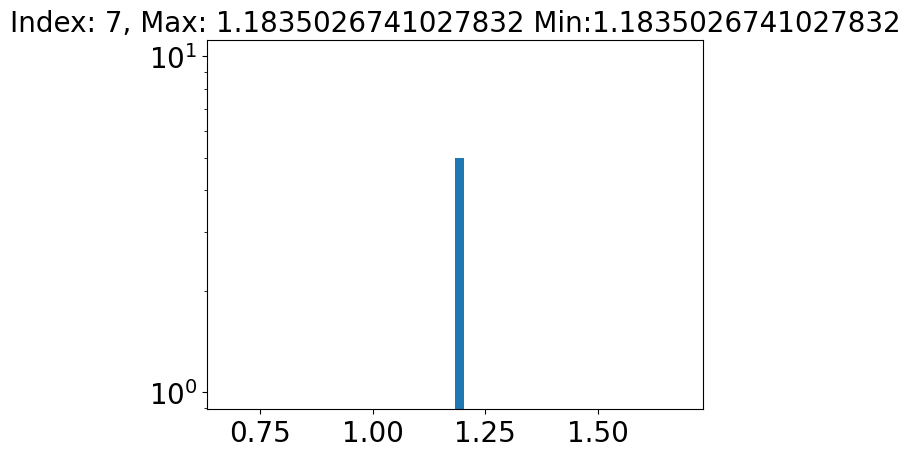

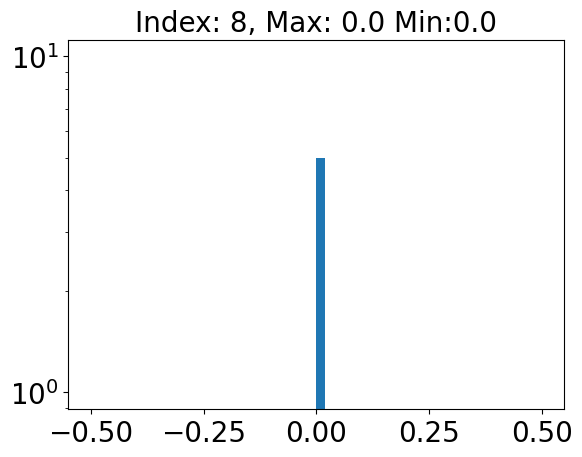

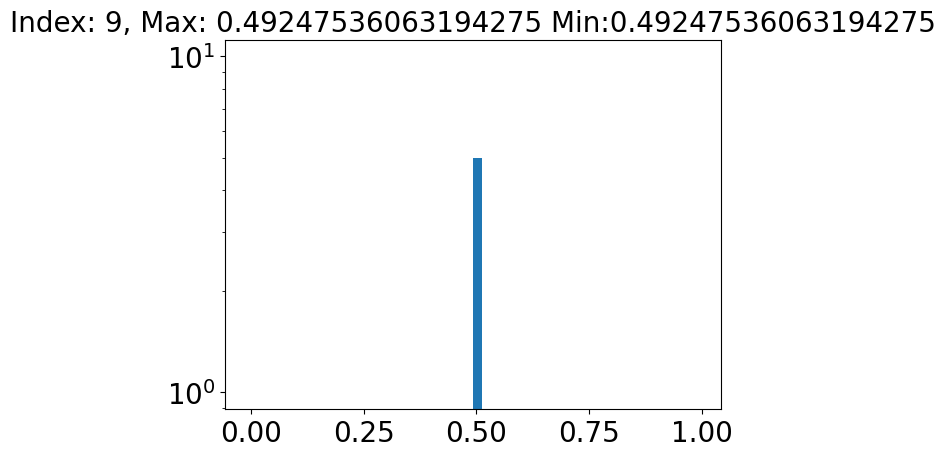

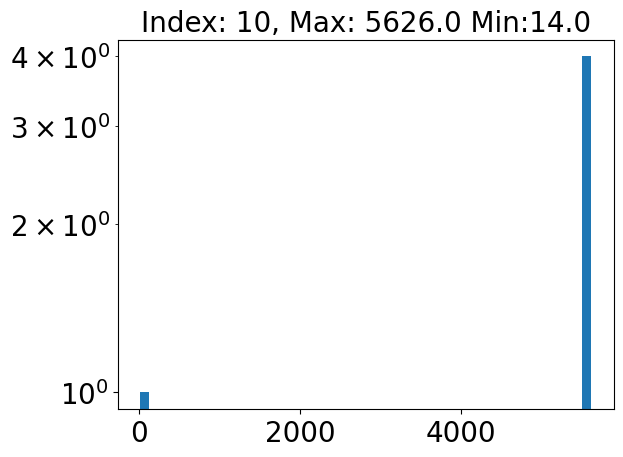

/opt/anaconda3/envs/PuandaRadio/lib/python3.10/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in divide
  f_indices = ((_unsigned_subtract(tmp_a, first_edge) / norm_denom)
/opt/anaconda3/envs/PuandaRadio/lib/python3.10/site-packages/numpy/lib/histograms.py:841: RuntimeWarning: invalid value encountered in cast
  indices = f_indices.astype(np.intp)


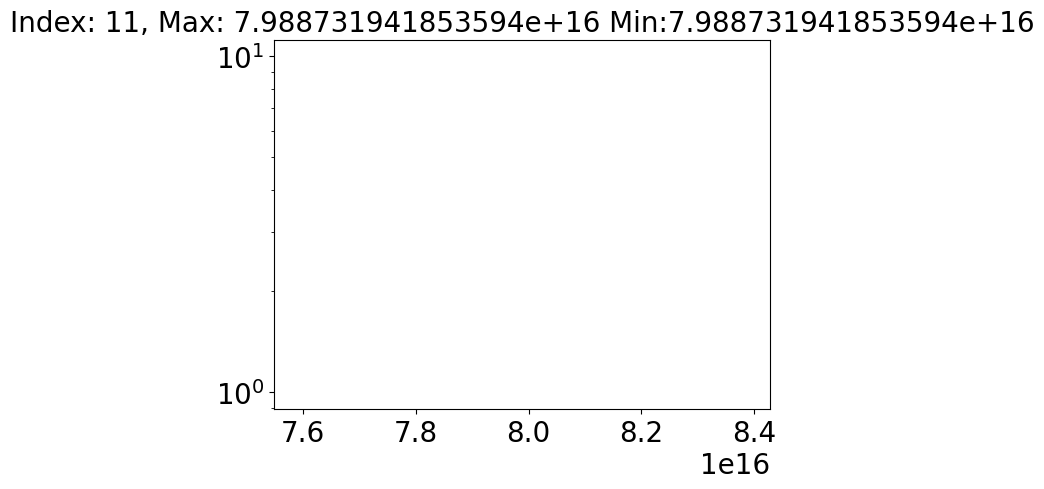

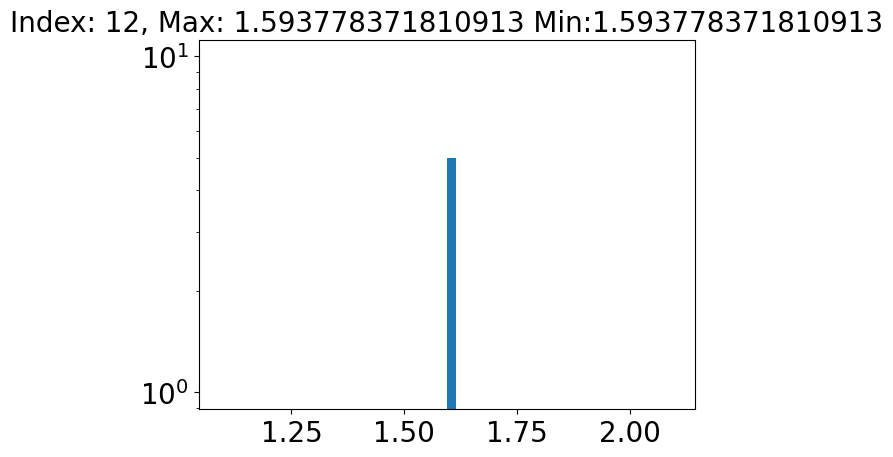

In [31]:
for i in range(0,13):
    plt.hist(meta_data[indices,i], bins=50)
    plt.title(f"Index: {i}, Max: {np.max(meta_data[indices,i])} Min:{np.min(meta_data[indices,i])}")
    plt.yscale('log')
    plt.show()

In [32]:
assert False

AssertionError: 

In [ ]:
plt.hist(input_data[indices].flatten(), bins=50)
plt.title(f"Input  Max: {np.max(input_data[indices])} Min:{np.min(input_data[indices])}")
plt.show()

In [33]:
low = np.inf
high = -np.inf
nbins = 100
# find the overall min/max
for chunk_id in np.array_split(indices, 30):
    chunk = output_vBvvB[chunk_id]
    low = np.minimum(chunk.min(), low)
    high = np.maximum(chunk.max(), high)
bin_edges = np.linspace(low, high, nbins + 1)
total = np.zeros(nbins, np.uint)

# iterate over your dataset in chunks of 1000 lines (increase or decrease this
# according to how much you can hold in memory)
for chunk_id in np.array_split(indices, 30):
    chunk = output_vBvvB[chunk_id]

    # compute bin counts over the 3rd column
    subtotal, e = np.histogram(chunk.flatten(), bins=bin_edges)

    # accumulate bin counts over chunks
    total += subtotal.astype(np.uint)
    
plt.bar(bin_edges[:-1], total, width=1)

ValueError: zero-size array to reduction operation minimum which has no identity

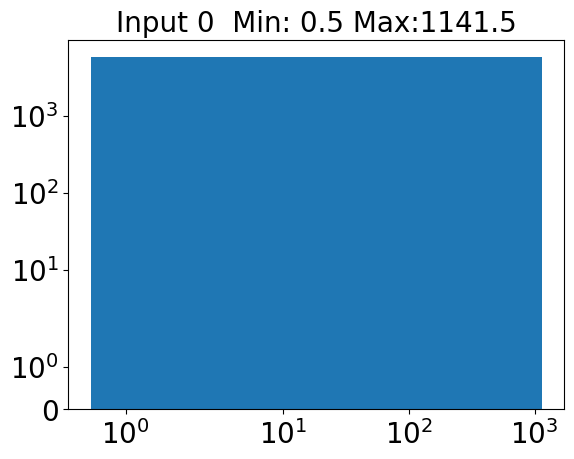

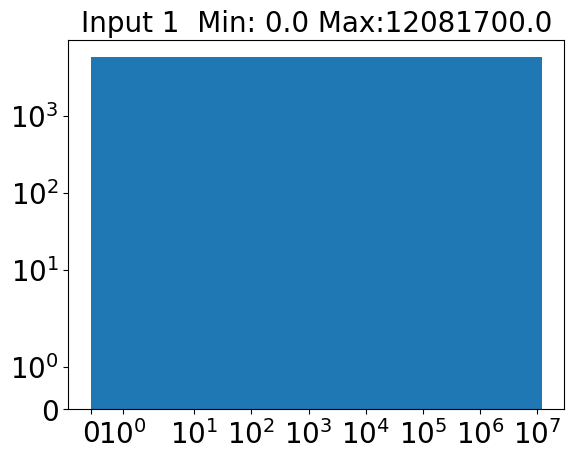

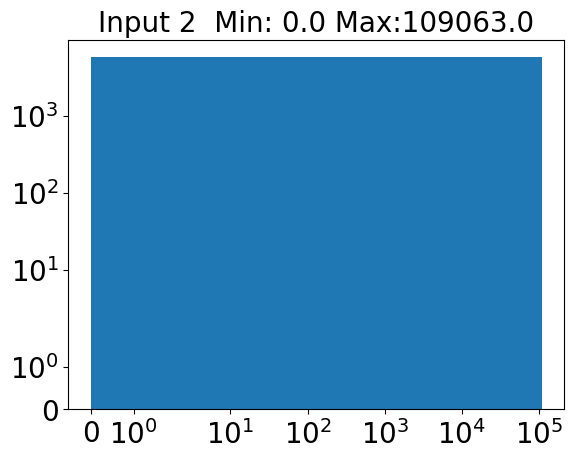

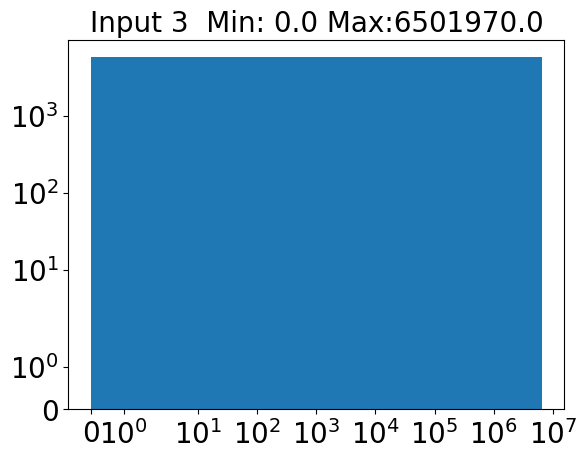

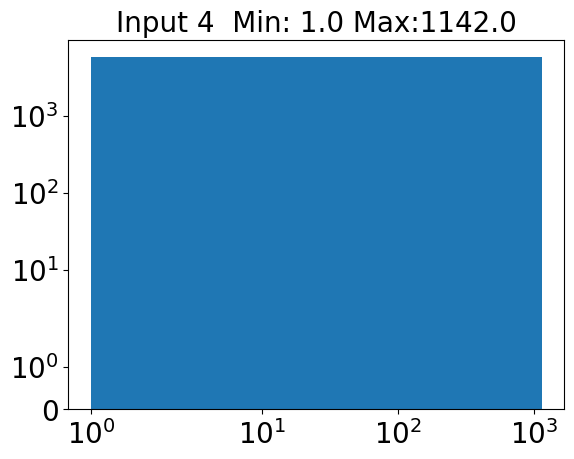

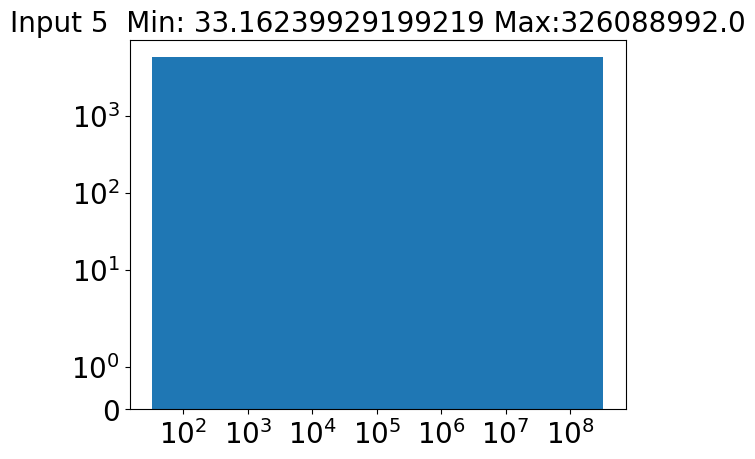

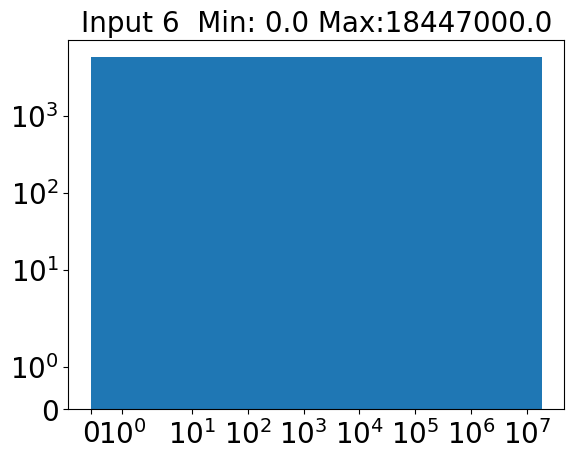

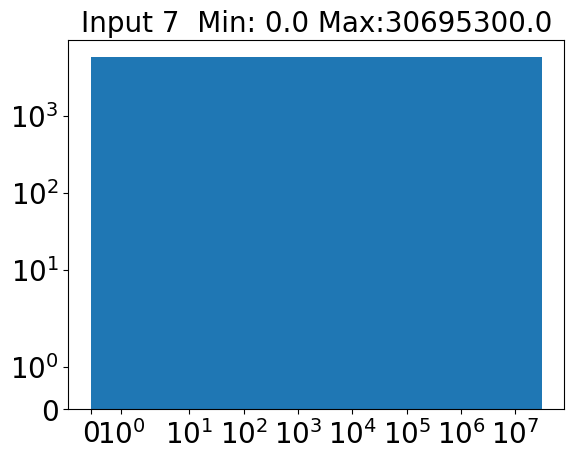

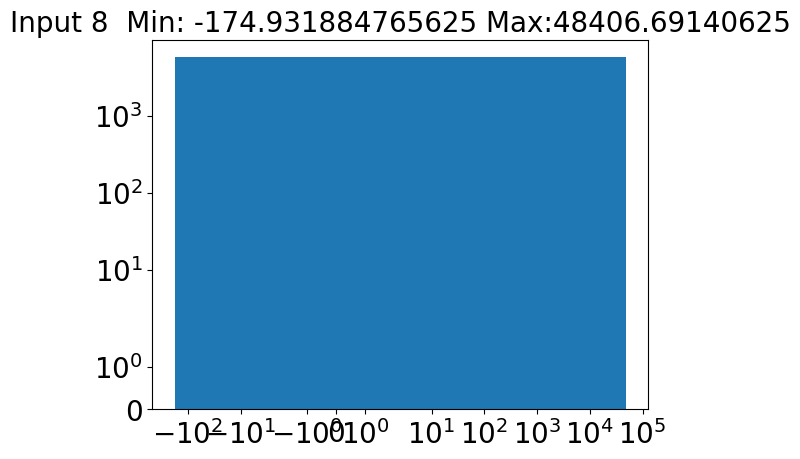

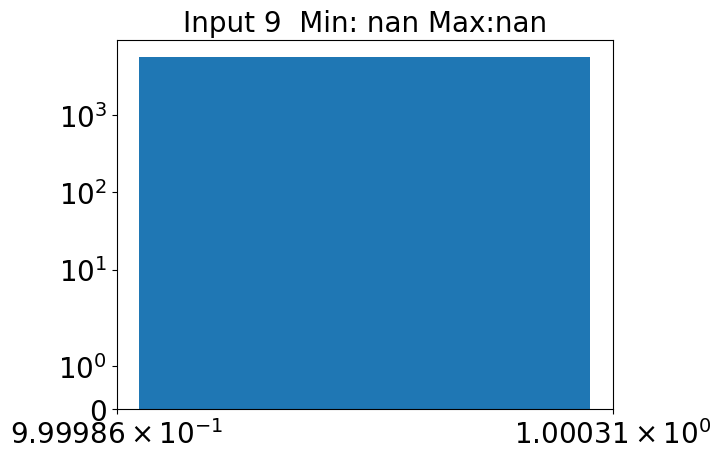

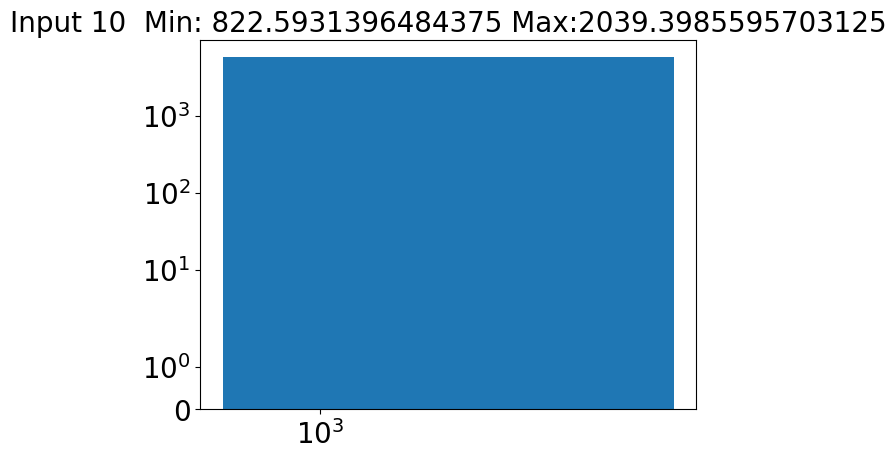

In [38]:
for i in range(11):
    data = input_data[indices, :, i]
    plt.hist(data.flatten(), bins=1)
    plt.title(f"Input {i}  Min: {np.min(data)} Max:{np.max(data)}")
    plt.xscale("symlog")
    plt.yscale("symlog")
    plt.show()

In [35]:
import numpy as np

In [36]:
np.arange(10)*5 + np.repeat(np.arange(5),

SyntaxError: incomplete input (2540361140.py, line 1)

In [ ]:
np.repeat(np.arange(10),5)

In [ ]:
np.repeat(np.arange(10),5)*5 + np.tile(np.arange(5), 10)

In [ ]:
np.tile(np.arange(5), 10)

In [ ]:
inp_data_real, inp_meta_real, antenna_pos_real, outp_meta_real, outp_data_real = dataset.data_of_single_shower(33)


In [ ]:
inp_meta_real

In [ ]:
inp_data_real, inp_meta_real, antenna_pos_real, outp_meta_real, outp_data_real = dataset.return_data(0.01)

In [ ]:
a = np.random.randint(10, size=(5,6,7))

In [ ]:
a[:,:,2].shape

In [ ]:
a.shape

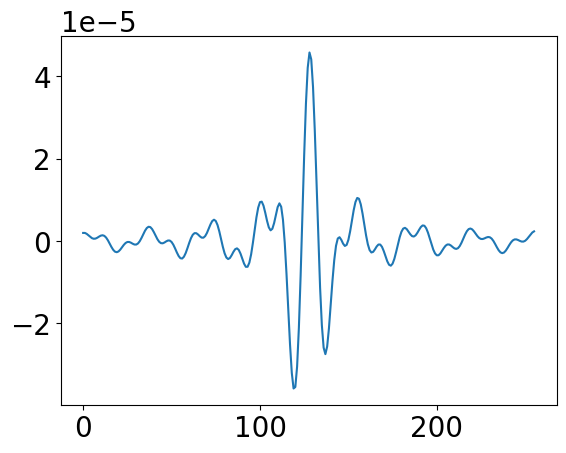

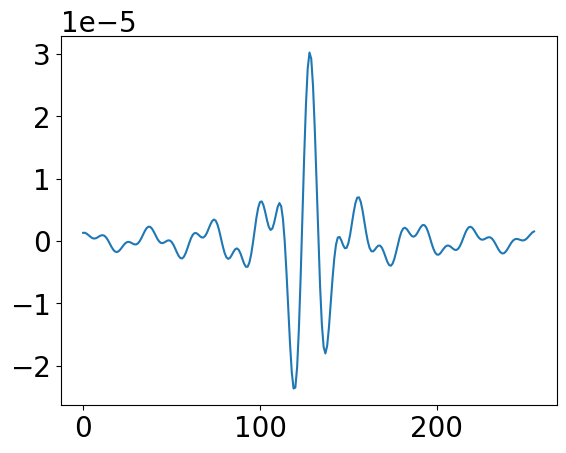

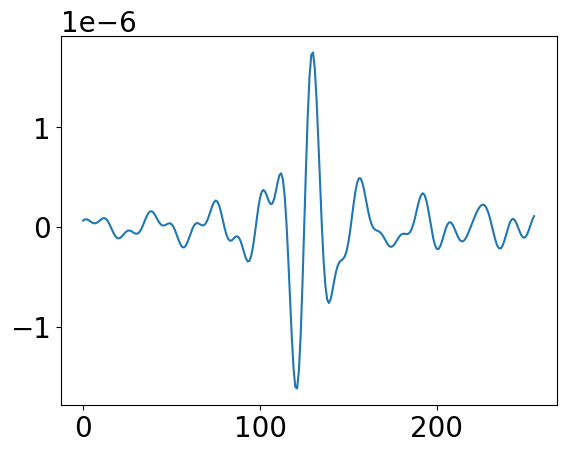

In [39]:
for i in range(3):
    plt.plot(output_vBvvB[0,0,:,i])
    plt.show()